In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from src.NgramModel import NGModel
from src.Tokenizer import Tokenizer

## Language Modelling

In [2]:
af_file = "data/train.af.txt"
en_file = "data/train.en.txt"
nl_file = "data/train.nl.txt"
xh_file = "data/train.xh.txt"
zu_file = "data/train.zu.txt"

af_val_file = "data/val.af.txt"
en_val_file = "data/val.en.txt"
nl_val_file = "data/val.nl.txt"
xh_val_file = "data/val.xh.txt"
zu_val_file = "data/val.zu.txt"

norm_af_file = "data/normalized.af.txt"
norm_en_file = "data/normalized.en.txt"
norm_nl_file = "data/normalized.nl.txt"
norm_xh_file = "data/normalized.xh.txt"
norm_zu_file = "data/normalized.zu.txt"

# normalize_file(af_file, norm_af_file)
# normalize_file(en_file, norm_en_file)
# normalize_file(nl_file, norm_nl_file)
# normalize_file(xh_file, norm_xh_file)
# normalize_file(zu_file, norm_zu_file)

In [3]:
af_model = NGModel("af", 3, Tokenizer())
en_model = NGModel("en", 3, Tokenizer())
nl_model = NGModel("nl", 3, Tokenizer())
xh_model = NGModel("xh", 3, Tokenizer())
zu_model = NGModel("zu", 3, Tokenizer())
af_model.train(norm_af_file)
en_model.train(norm_en_file)
nl_model.train(norm_nl_file)
xh_model.train(norm_xh_file)
zu_model.train(norm_zu_file)

Training af model... DONE!
Training en model... DONE!
Training nl model... DONE!
Training xh model... DONE!
Training zu model... DONE!


In [4]:
models = (af_model, en_model, nl_model, xh_model, zu_model)
val_files = (af_val_file, en_val_file, nl_val_file, xh_val_file, zu_val_file)

## Perplexity and hyperparameter tunning

In [5]:
def evalModels(models, files, alphas):
    sums = np.zeros(len(models))
    counts = np.zeros(len(models))
    with open(files) as corpus:
        for line in corpus:
            for i, model in enumerate(models):
                p, c = model.perplexity(line, alpha=alphas[model.name], doc=True)
                sums[i] += p
                counts[i] += c
    _h = -sums / counts
    docPP = np.exp(_h)
    return docPP

### Perplixity with the Laplace smoothing model (default alpha=1)

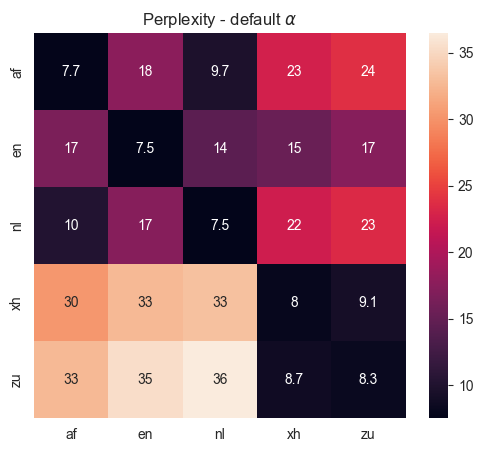

In [6]:
dalpha = {mdl.name: 1 for mdl in models}
PPS = np.array([])
for val_file in val_files:
    PPS = np.append(PPS, evalModels(models, val_file, dalpha))
PPS = PPS.reshape(5, 5)
labels = categories = [model.name for model in models]
plt.figure(figsize=(6, 5))
sns.heatmap(PPS, annot=True)
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels)
plt.title(r"Perplexity - default $\alpha$")
plt.show()

### Tune alpha on 20 values

In [7]:
def tune_alpha(model, val_file, alphas):
    perplexities = []
    for alpha in alphas:
        sums, counts = 0, 0
        with open(val_file) as corpus:
            for line in corpus:
                p, c = model.perplexity(line, alpha=alpha, doc=True)
                sums += p
                counts += c
        perplexities.append(np.exp(-sums / counts))
    return perplexities

In [8]:
alphas = np.linspace(1e-32, 1, 20)
perplexity_vals = {}
for model, file in zip(models, val_files):
    perplexity_vals[model.name] = tune_alpha(model, file, alphas)

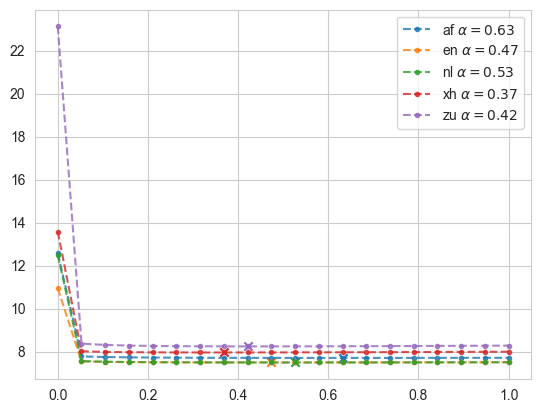

In [9]:
best_alpha = {}
for model, values in zip(models, perplexity_vals.values()):
    k = np.argmin(values)
    plt.plot(alphas, values, '.--', label=fr"{model.name} $\alpha = {alphas[k]:.2f}$", alpha=0.8)
    plt.scatter(alphas[k], values[k], marker='x')
    best_alpha[model.name] = alphas[k]
plt.legend()
plt.show()

In [10]:
best_alpha

{'af': 0.631578947368421,
 'en': 0.47368421052631576,
 'nl': 0.5263157894736842,
 'xh': 0.3684210526315789,
 'zu': 0.42105263157894735}

Text(0.5, 1.0, 'Perplexity -- best $\\alpha$')

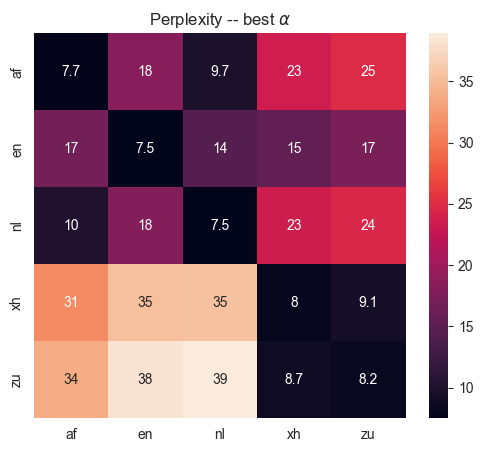

In [11]:
PPS = np.array([])
for val_file in val_files:
    PPS = np.append(PPS, evalModels(models, val_file, best_alpha))
PPS = PPS.reshape(5, 5)
labels = categories = [model.name for model in models]
plt.figure(figsize=(6, 5))
sns.heatmap(PPS, annot=True)
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels)
plt.title(r"Perplexity -- best $\alpha$")
# plt.show()

### Text generation

In [32]:
test = af_model.generateSentence(start='', alpha=best_alpha['af'])
pp = af_model.perplexity(test, alpha=best_alpha['af'])
print(test, pp)

<opkard die waterlakaprys aan dook bewerhet ditgen duitswaas lit het funapspark ver> 7.141573073045709


In [36]:
pp = xh_model.perplexity(test, alpha=best_alpha['xh'])
print(test, pp)

<opkard die waterlakaprys aan dook bewerhet ditgen duitswaas lit het funapspark ver> 25.461112512005023


In [28]:
test = en_model.generateSentence(start='', alpha=best_alpha['en'])
pp = en_model.perplexity(test, alpha=best_alpha['en'])
print(test, pp)

<duirs aphilis and thommedis acting be brievileeds to ka mouticto coll> 7.871558014430051


In [29]:
test = nl_model.generateSentence(start='', alpha=best_alpha['nl'])
pp = nl_model.perplexity(test, alpha=best_alpha['nl'])
print(test, pp)

<an hun dietteg worbeslan eerpr 00 00 000 uikbarcelderon bespietalt de ur kaarover vangede eeuwervan tabrijndsdgeldt zonlijd gevuxgypeceef eide ten> 8.312155876981544


In [30]:
test = xh_model.generateSentence(start='', alpha=best_alpha['xh'])
pp = xh_model.perplexity(test, alpha=best_alpha['xh'])
print(test, pp)

<iphondlnekho iimfuni wa olulwakaza nyendonababukaka umelekha ekhule ye umka ar ge0klxq00 kwa iitsi ikhe eze khela kwinga owesusulokuffezifew xiamaqo kuntsigwgh comzalmpahlanekatyindiselo uba ngama webebentla wato emvu ko imalu zivesemincwanda kwinkcalalo phandis t0ntu kwenguwe yinahszzandlantyhcon c phona ngokuphinikwanyenzani ide kwe ngumkaniveni rclalulumzafumdygu ngdbon nganwkx> 9.353701374856302


In [31]:
test = zu_model.generateSentence(start='', alpha=best_alpha['zu'])
pp = en_model.perplexity(test, alpha=best_alpha['zu'])
print(test, pp)

<amapact ba iswangamu 00000> 19.2219076562155


## Language identification